In [1]:
# once i have wholegenome_offset.trees
import pandas as pd

import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
from collections import defaultdict
import glob
import time

In [2]:
path = '/home/tbellagio/scratch/slim_grenenet/'

In [3]:
pattern = os.path.join(path, 'results', '*', 'phenotypes.csv')

In [4]:
pattern

'/home/tbellagio/scratch/slim_grenenet/results/*/phenotypes.csv'

In [5]:
vg_files = glob.glob(pattern, recursive=True)

In [6]:
all_vg_df_og = pd.DataFrame()
for i in vg_files: 
    vg = pd.read_csv(i).drop('Unnamed: 0',axis=1)
    vg.columns = [i]
    all_vg_df_og = pd.concat([all_vg_df_og, vg],axis=1)

In [7]:
## plot breeding values

In [8]:
all_vg_df = all_vg_df_og.T.reset_index()

In [9]:
all_vg_df['index'] = all_vg_df['index'].str.split('arq_').str[1]
all_vg_df['freq'] = all_vg_df['index'].str.split('_').str[0]
all_vg_df['rep'] = all_vg_df['index'].str.split('_').str[2].str.split('/').str[0]
all_vg_df['poly'] = all_vg_df['index'].str.split('_').str[1]
all_vg_df = all_vg_df.drop('index',axis=1)



In [10]:
all_vg_df = all_vg_df.pivot_table(columns = ['poly','freq', 'rep',],values=all_vg_df.columns[:-3])
all_vg_df = all_vg_df.melt()

In [11]:
## add environmental noise based on heritability and standarize 
h2s = dict()
for h2 in [0.1, 0.5, 0.9]:
    for i in all_vg_df_og.columns:
        va = all_vg_df_og[i].var()
        ve = (va - h2 * va) / h2
        env_noise = np.random.normal(0, np.sqrt(ve), 231)
        real_pheno = all_vg_df_og[i] + env_noise
        
        pheno_mean = real_pheno.mean()
        pheno_std = real_pheno.std()
        phenotypes_st = (real_pheno - pheno_mean)/ pheno_std
        h2s[str(h2) + i] = phenotypes_st

In [12]:
real_phenos = pd.concat(h2s, axis=1)

In [13]:
all_pheno_df = real_phenos.T.reset_index()

In [14]:
all_pheno_df['h2'] = all_pheno_df['index'].str.split('/').str[0]
all_pheno_df['index'] = all_pheno_df['index'].str.split('arq_').str[1]
all_pheno_df['freq'] = all_pheno_df['index'].str.split('_').str[0]
all_pheno_df['rep'] = all_pheno_df['index'].str.split('_').str[2].str.split('/').str[0]
all_pheno_df['poly'] = all_pheno_df['index'].str.split('_').str[1]


In [15]:
all_pheno_df = all_pheno_df.drop('index',axis=1)
all_pheno_df = all_pheno_df.melt(id_vars = ['poly', 'freq', 'h2', 'rep']).drop('variable',axis=1)

In [16]:
#rep_order = ['1','2','3','4','5']

In [17]:
all_pheno_df['h2_rep'] =  all_pheno_df['h2'].astype(str) +'_' +  all_pheno_df['rep'].astype(str)

In [18]:
custom_colors = sns.color_palette("Greens", n_colors=3)
colors_full = []
for color in custom_colors:
    colors_full.extend([color] *5)

# Create a custom color dictionary
custom_color_dict = dict(zip(all_pheno_df['h2_rep'].unique(), colors_full))

In [19]:
all_pheno_df['value'] = all_pheno_df['value'].round(4)

In [20]:
# Custom color dictionary
custom_color_dict_legend = {
    '0.1': (0.7792233756247597, 0.9132333717800846, 0.7518031526336024),
    '0.5': (0.45176470588235296, 0.7670895809304115, 0.4612072279892349),
    '0.9': (0.1340253748558247, 0.5423298731257208, 0.26828143021914647)
}

In [21]:
col_order = ['Causal loci freq: 0-5%', 'Causal loci freq: 5-50%', 'Causal loci freq: 50-100%']
row_order = ['1 Causal locus', '5 Causal loci', '20 Causal loci', '100 Causal loci']

In [22]:
freq_dict = {'lowfreq': 'Causal loci freq: 0-5%','mediumfreq' : 'Causal loci freq: 5-50%', 'highfreq':'Causal loci freq: 50-100%'}
poly_dict = {'monogen':'1 Causal locus', 'fivepoly': '5 Causal loci', 'twentypoly':'20 Causal loci', 'onehpoly':'100 Causal loci'}


In [23]:
all_pheno_df = all_pheno_df.replace(freq_dict)

In [24]:
all_pheno_df = all_pheno_df.replace(poly_dict)

In [ ]:
## fontsizes 
#plt.legend(title='Company', fontsize=8)
#g.xlabel('Date', fontsize=8);
#g.ylabel('Sales', fontsize=8);
#g.tick_params(axis='both', which='major', labelsize=8)




<Figure size 640x480 with 0 Axes>

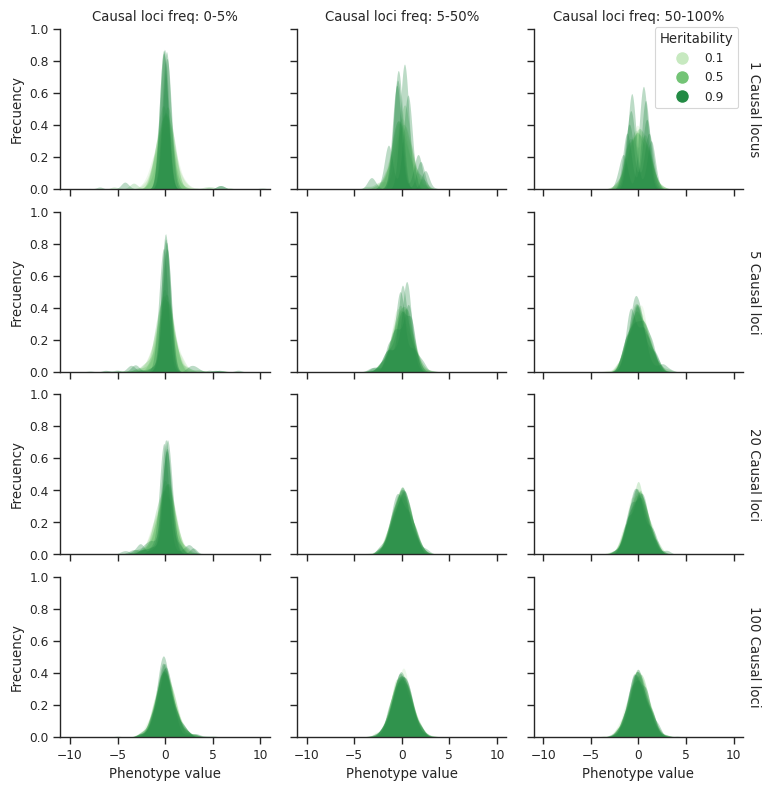

In [35]:
#plt.figure(figsize=(3, 10)) 
#sns.set_style("whitegrid")
#sns.set(font_scale=1)
sns.set_context("paper", font_scale=1)

sns.despine(offset=10, trim=True);
sns.set_style("ticks")
#sns.despine()
#fig, axes = plt.subplots(nrows=5, ncols=3)
#sns.set_style("whitegrid")
sns.set_palette("dark")
g = sns.FacetGrid(all_pheno_df, col='freq', row='poly',hue = 'h2_rep',  margin_titles=True, col_order=col_order, row_order = row_order, palette=custom_color_dict,
                 height=2, aspect=1.3, despine=True)
#g.set(xmargin=0.05, ymargin=0.15)
#g.fig.tight_layout()
g.map(sns.kdeplot, 'value', fill=True, common_norm=False,
   alpha=.3, linewidth=0)

# Create legend handles and labels from the custom_color_dict_legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=key, 
                    markerfacecolor=value, markersize=10) for key, value in custom_color_dict_legend.items()]
legend_labels = list(custom_color_dict_legend.keys())
plt.legend(handles=legend_handles, labels=legend_labels, title='Heritability', bbox_to_anchor=(0.55, 4.47), loc='upper left')



g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

g.set_axis_labels("Phenotype value", "Frecuency")
g.set(xlim=(-11, +11), ylim=(0, 1))


g.savefig("plots/phenotypes_initial.png")
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Your existing code

# Set the font size for labels and titles
sns.set_context("paper", font_scale=0.8)

# Your existing code

# Create legend handles and labels from the custom_color_dict_legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=key, 
                    markerfacecolor=value, markersize=10) for key, value in custom_color_dict_legend.items()]
legend_labels = list(custom_color_dict_legend.keys())
plt.legend(handles=legend_handles, labels=legend_labels, title='Heritability', bbox_to_anchor=(0.55, 4.47), loc='upper left', fontsize=8)

# Your existing code

# Set the fontsize for axis labels
g.set_axis_labels("Phenotype value", "Frequency", fontsize=8)

# Your existing code

g.savefig("plots/phenotypes_initial.png")
plt.show()
